# Processing MT netCDF files with OPENDAP 

In [194]:
%reset -f

#%whos

In [195]:
# import modules

import os
import matplotlib.pyplot as plt
import subprocess
from multiprocessing import Process
import numpy as np
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from datetime import datetime, timedelta
import pandas as pd
import glob
import datetime
from subprocess import call
%matplotlib inline

## Open up our netCDF file

In [196]:
working_dir = '/g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf'
os.chdir(working_dir)
#TS_path = '/g/data/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/netCDF_test.nc'
TS_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/my80_dev/netCDF_test.nc'
TS = Dataset(TS_path)

## See what data is in our files

In [197]:
for item in TS.dimensions:
    print TS.dimensions[item].name, TS.dimensions[item].size

vars = TS.variables.keys()
for item in vars:
    print 'Variable: \t', item
    print 'Dimensions: \t', TS[item].dimensions
    print 'Shape:    \t', TS[item].shape, '\n'

bx 82800000
by 82800000
ex 82800000
ey 82800000
latitude 1
longitude 1
time 82800000
Variable: 	latitude
Dimensions: 	(u'latitude',)
Shape:    	(1,) 

Variable: 	ex
Dimensions: 	(u'ex',)
Shape:    	(82800000,) 

Variable: 	longitude
Dimensions: 	(u'longitude',)
Shape:    	(1,) 

Variable: 	ey
Dimensions: 	(u'ey',)
Shape:    	(82800000,) 

Variable: 	bx
Dimensions: 	(u'bx',)
Shape:    	(82800000,) 

Variable: 	by
Dimensions: 	(u'by',)
Shape:    	(82800000,) 

Variable: 	time
Dimensions: 	(u'time',)
Shape:    	(82800000,) 



## Extract some time-series data

In [198]:
start_point = 0
end_point = 20000000

ex = TS.variables['ex'][start_point:end_point]
ey = TS.variables['ey'][start_point:end_point]
bx = TS.variables['bx'][start_point:end_point]
by = TS.variables['by'][start_point:end_point]

time = TS.variables['time'][start_point:end_point]

lat = TS.variables['latitude']
lon = TS.variables['longitude']

## Plot some TS data

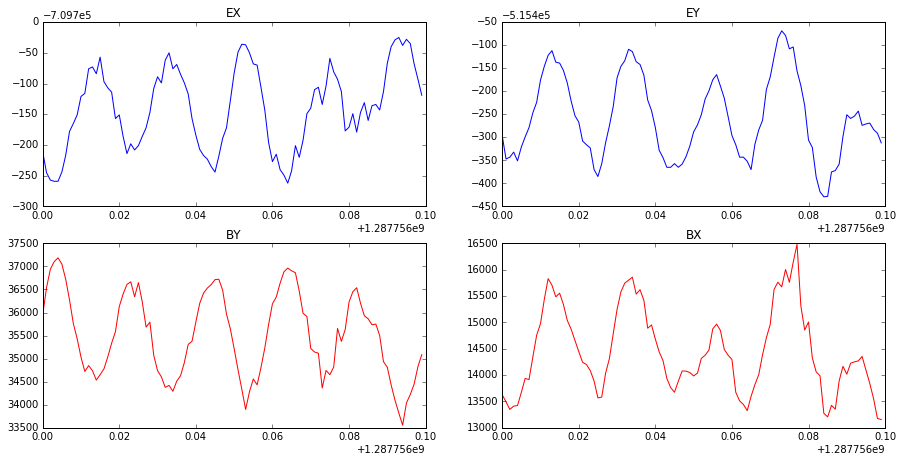

In [192]:
plt.rcParams['figure.figsize'] = [65, 7]

x = 0
y = 100


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(time[x:y], ex[x:y])
ax1.set_title('EX')
ax2.plot(time[x:y], ey[x:y])
ax2.set_title('EY')
ax3.plot(time[x:y], by[x:y], color='r')
ax3.set_title('BY')
ax4.plot(time[x:y], bx[x:y], color='r')
ax4.set_title('BX')

## Write TS ascii files ready for BIRRP

In [199]:
%%time

def writets(name,ts):
    """
    write TS as ascii files
    """
    result = np.savetxt(name, ts, fmt="%i")
    proc = os.getpid()
    print('{0} savetxt by process id: {1}'.format(
        name, proc))
 
if __name__ == '__main__':
    names = ['ex','ey','bx','by','time'] 
    timeseries = [ex, ey, bx, by, time]
    procs = []
 
    for name, ts in zip(names,timeseries):
        proc = Process(target=writets, args=(name,ts,))
        procs.append(proc)
        proc.start()
 
    for proc in procs:
        proc.join()

time savetxt by process id: 28262
bx savetxt by process id: 28260
ex savetxt by process id: 28258
by savetxt by process id: 28261
ey savetxt by process id: 28259
CPU times: user 10 ms, sys: 76 ms, total: 86 ms
Wall time: 1min 20s


## Create header information for mseed conversion

In [200]:
BX = [f for f in os.listdir(working_dir) if f.startswith('bx') and f.endswith('bx')]
BY = [f for f in os.listdir(working_dir) if f.startswith('by') and f.endswith('by')]
EX = [f for f in os.listdir(working_dir) if f.startswith('ex') and f.endswith('ex')]
EY = [f for f in os.listdir(working_dir) if f.startswith('ey') and f.endswith('ey')]
#TIME = [f for f in os.listdir(working_dir) if f.startswith('time')]

In [201]:
import datetime
#start_time = datetime.datetime.fromtimestamp(int(time[0]/1000)).strftime('%Y-%m-%d'+'T' +'%H:%M:%S'+'.0000')
start_time = datetime.datetime.fromtimestamp(int(time[0])).strftime('%Y-%m-%d'+'T' +'%H:%M:%S'+'.0000')
station_BX = 'MagX_CP1L01_Capricorn_BX_QUAL'
station_BY = 'MagY_CP1L01_Capricorn_BY_QUAL'
station_EX = 'ElecX_CP1L01_Capricorn_EX_QUAL'
station_EY = 'ElecY_CP1L01_Capricorn_EY_QUAL'
samples = 20000000
sampling_rate_Hz = 1000

string_bx =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_BX, samples, sampling_rate_Hz, start_time)
string_by =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_BY, samples, sampling_rate_Hz, start_time)
string_ex =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_EX, samples, sampling_rate_Hz, start_time)
string_ey =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_EY, samples, sampling_rate_Hz, start_time)


In [202]:
string = [string_ex, string_ey, string_bx, string_by]

## Add header to ASCII files for mseed conversion

In [204]:
%%time
from itertools import izip, count

def mseedheader(ascfiles,string):
        proc = os.getpid()
        print('{0} added header by process id: {1}'.format(ascfiles, proc))
        for i in ascfiles:
            with open(i,'r') as original:
                data = original.read()
                with open(i,'w') as modified:
                    modified.write(string + data)

 
if __name__ == '__main__':
    asciifiles = [EX, EY, BX, BY]
    string = [string_ex, string_ey, string_bx, string_by]
    procs = []
 
    for i,fs,st in izip(count(),asciifiles,string):
        proc = Process(target=mseedheader, args=(fs,st,))
        procs.append(proc)
        proc.start()
 
    for proc in procs:
        proc.join()

['ex'] added header by process id: 28802
['ey'] added header by process id: 28805
['bx'] added header by process id: 28808
['by'] added header by process id: 28811
CPU times: user 8 ms, sys: 64 ms, total: 72 ms
Wall time: 1.74 s


## Convert ASCII files to miniseed.

In [205]:
%%time

def convert2mseed(files):
    for input_file in files:
        proc = os.getpid()
        print('create mseed {0} by process id: {1}'.format(input_file, proc))
        output_file = input_file + ".mseed"
        call(['ascii2mseed', input_file, "-o", output_file])
    
if __name__ == '__main__':
    types = [EX, EY, BX, BY] 
    procs = []
 
    for fs in types:
        proc = Process(target=convert2mseed, args=(fs,))
        procs.append(proc)
        proc.start()
 
    for proc in procs:
        proc.join()

create mseed ex by process id: 28830
create mseed ey by process id: 28833
create mseed bx by process id: 28837
create mseed by by process id: 28841
CPU times: user 999 µs, sys: 71 ms, total: 72 ms
Wall time: 4.97 s


## Convert TS files back to useable BIRRP input

In [207]:
%%bash

for i in ex ey bx by;
do
    sed -i -e 1d "$i" &
done
wait 

## Check that BIRRP input file lengths are the same

In [208]:
%%bash

for i in bx by ex ey;
do
    wc "$i" &
done
wait

 20000000  20000000 120000399 by
 20000000  20000000 119015069 bx
 20000000  20000000 160000000 ey
 20000000  20000000 160000000 ex


### To view our miniseed time-series in snuffler, open up a VDI terminal in our working directory and run:

``` 
    $ module load snuffler
    $ snuffler <*.mseed>
    
```

## Create birrpstring

In [209]:
birrpstring = TS.birrpstring

## Run BIRRP 

In [210]:
from subprocess import Popen, PIPE

p = Popen('birrp-5.3.2', stdin=PIPE) #NOTE: no shell=True here
p.stdin.write(birrpstring)

## Convert BIRRP output to EDI file

### write BIRRP config file

In [211]:
birrp_cfg = TS.birrp_cfg

In [212]:
with open('birrp.cfg','w') as text_file:
    text_file.write("%s" %birrp_cfg)

### write survey config file

In [5]:
# uncomment to see the netCDF metadata

# for attr in TS.ncattrs():
#     print attr, '=', getattr(TS, attr)

In [213]:
# extract the survey config file from our netCDF file

survey_cfg = TS.survey_cfg

In [214]:
# write the survey.cfg file

with open('survey.cfg','w') as text_file:
    text_file.write("%s" %survey_cfg)

### write EDI file

In [215]:
# directory where MTpy is installed

mtpy_directory = '/short/z00/nre900/MT/mtpy/'

os.chdir(mtpy_directory)

from mtpy.processing.birrp import convert2edi

os.chdir(working_dir)

In [216]:
# convert BIRRP outputs to EDI files

stationname = 'c01'
survey_configfile = 'survey.cfg'
in_dir = '.'
birrp_configfile = 'birrp.cfg'
convert2edi(stationname, in_dir, survey_configfile, birrp_configfile, out_dir = None)

'/g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/C01.edi'

### plotting from EDI

In [222]:
os.chdir(mtpy_directory)

# import mtpy.imaging.mtpl.MTplottools as MTplot

# os.chdir(working_dir)

# edipath = "."
# edilist = [os.path.join(edipath,edi) for edi in os.listdir(edipath) if edi.find('.edi')>0]

In [223]:
import mtpy.core.mt as mt

In [224]:
os.chdir(working_dir)

### Let's use the EDI provided in our netCDF file

In [218]:
edi_fn = TS.EDI
#edi_fn = '/g/data3/my80/States_and_Territories/WA/Broadband/Capricorn/TS/Capricorn_CP1_BB/CP1B01/c01.edi'

In [219]:
with open('c01b.edi','w') as text_file:
    text_file.write("%s" %edi_fn)

In [220]:
edi = '/g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01b.edi'

In [225]:
mt_obj = mt.MT(edi)

 ...nulled all attributes of current MTedi.Edi instance.
reading in Edi file: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01b.edi
z
Could not read Tipper section: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01b.edi
Flipping arrays to be ordered from short period to long


 ...nulled all attributes of current MTedi.Edi instance.
reading in Edi file: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01b.edi
z
Could not read Tipper section: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01b.edi
Flipping arrays to be ordered from short period to long


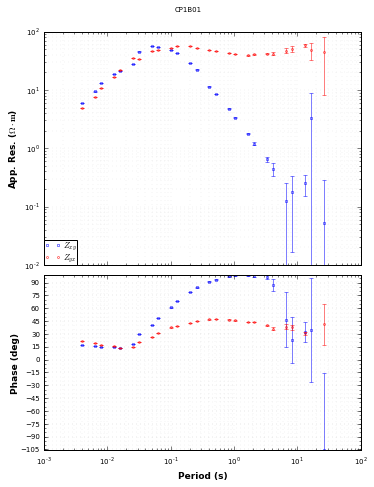

In [226]:
mt_plot = mt_obj.plot_mt_response()

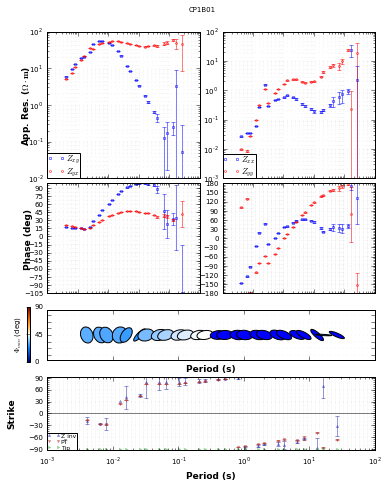

In [227]:
mt_plot.plot_pt = 'y'
mt_plot.plot_strike = 'ytip'
mt_plot.plot_num = 2
mt_plot.redraw_plot()

In [16]:
# @hidden_cell

# %%time

# for f in BX:
#     with open(f,'r') as original:
#         data = original.read()
#         with open(f,'w') as modified:
#             modified.write(string_bx + data)
    
# for f in BY:
#     with open(f,'r') as original:
#         data = original.read()
#         with open(f,'w') as modified:
#             modified.write(string_by + data)

# for f in EX:
#     with open(f,'r') as original:
#         data = original.read()
#         with open(f,'w') as modified:
#             modified.write(string_ex + data)
            
# for f in EY:
#     with open(f,'r') as original:
#         data = original.read()
#         with open(f,'w') as modified:
#             modified.write(string_ey + data)

SyntaxError: invalid syntax (<ipython-input-16-df22a657763f>, line 27)

In [11]:
#ascii_to_mseed_exec = '/short/z00/nre900/MT/ascii2mseed/ascii2mseed'
# ascii_to_mseed_exec = 'ascii2mseed'

# types = ('ex', 'ey', 'bx', 'by')
# files_grabbed = []

# for files in types:
#     files_grabbed.extend(glob.glob(files))


# for input_file in files_grabbed:
#     output_file = input_file + ".mseed" 
#     call([ascii_to_mseed_exec, input_file, "-o", output_file])  

In [131]:
#subprocess.call("birrp-5.3.2" + "<" + "CP1.script", shell=True)
#os.system("birrp-5.3.2" + "<" + "CP1.script")

0

In [8]:
# birrpstring = """0
# 2
# 2
# 2
# -10
# 65536,10
# y
# 0,0.999
# 0.4
# c01
# 0
# 1
# 3
# 0
# 0
# 20000000
# 0
# {0}
# 0
# 0
# {1}
# 0
# 0
# {2}
# 0
# 0
# {3}
# 0
# 0
# {4}
# 0
# 0
# {5}
# 0
# 0,90,0
# 0,90,0
# 0,90,0
# """.format('ex','ey','bx','by','bx','by')

In [115]:
# station = TS.station
# b_interface_box_gain = TS.variables['bx'].interface_box_gain
# b_logger_gain = TS.variables['bx'].logger_gain
# b_xaxis_azimuth = TS.variables['bx'].azimuth
# b_yaxis_azimuth = TS.variables['by'].azimuth
# box = TS.boxnumber
# date = TS.surveydate
# e_interface_box_gain = TS.variables['ex'].interface_box_gain
# e_instrument_type = TS.variables['ex'].instrument_type
# e_logger_gain = TS.variables['ex'].logger_gain
# e_logger_type = TS.variables['ex'].instrument_type
# e_xaxis_azimuth = TS.variables['ex'].azimuth
# e_xaxis_length = TS.variables['ex'].dipole_length
# e_yaxis_azimuth = TS.variables['ey'].azimuth
# e_yaxis_length = TS.variables['ey'].dipole_length
# elevation = TS.elevation
# hx = TS.hx
# hy = TS.hy
# hz = TS.hz
# lat = lat[0]
# location = TS.location
# lon = lon[0]
# station_type = TS.station_type
# sampling_interval = TS.sampling_interval

In [13]:
# surveystring = """[{0}]
# b_instrument_amplification = {1}
# b_instrument_type = coil
# b_logger_gain = {2}
# b_logger_type = zen
# b_xaxis_azimuth = {3}
# b_yaxis_azimuth = {4}
# box = {5}
# date = {6}
# e_instrument_amplification = {7}
# e_instrument_type = {8}
# e_logger_gain = {9}
# e_logger_type = {10}
# e_xaxis_azimuth = {11}
# e_xaxis_length = {12}
# e_yaxis_azimuth = {13}
# e_yaxis_length = {14}
# elevation = {15}
# hx = {16}
# hy = {17}
# hz = {18}
# lat = {19}
# location = {20}
# lon = {21}
# station = {0}
# station_type = {22}
# sampling_interval = {23}
# """.format(station,b_interface_box_gain,b_logger_gain,b_xaxis_azimuth,b_yaxis_azimuth,box,date,e_interface_box_gain,e_instrument_type,e_logger_gain,e_logger_type,e_xaxis_azimuth,e_xaxis_length,e_yaxis_azimuth,e_yaxis_length,elevation,hx,hy,hz,lat,location,lon,station_type,sampling_interval)

In [172]:
# survey_cfg = """[c01]
# b_instrument_amplification = 10
# b_instrument_type = coil
# b_logger_gain = 1
# b_logger_type = zen
# b_xaxis_azimuth = 0
# b_yaxis_azimuth = 90
# box = 26
# date = 2010/10/23
# e_instrument_amplification = 10
# e_instrument_type = Ag-AgCl electrodes
# e_logger_gain = 1
# e_logger_type = Ag-AgCl electrodes
# e_xaxis_azimuth = 0
# e_xaxis_length = 46 m
# e_yaxis_azimuth = 90
# e_yaxis_length = 49 m
# elevation = 2113.2
# hx = 2274
# hy = 2284
# hz = 2254
# lat = -27.1000003815
# location = Earth
# lon = 134.5
# station = c01
# station_type = mt
# sampling_interval = all
# """


In [173]:
# birrp_cfg = """[DEFAULT]
# input_level = 0
# number_of_output_TS = 2
# number_of_input_TS = 2
# tbw_for_prolate_data_window = 2
# data_sample_interval = 10
# initial_section_length_and_maximum_number_of_sections = 65536,10
# are_these_values_acceptable = y
# robustness_and_leverage_parameters = 0,0.999
# 2nd_stage_coherence_threshold = 0.4
# output_filename_root = c01
# output_level = 0
# number_of_data_pieces = 1
# ar_filter_length = 3
# file_mode = 0
# input_mode = 0
# number_of_points_to_read = 20000000
# number_of_filter_parameters_ex = 0
# data_filename_ex = ex
# number_of_points_to_skip_ex = 0
# number_of_filter_parameters_ey = 0
# data_filename_ey = ey
# number_of_points_to_skip_ey = 0
# number_of_filter_parameters_bx = 0
# data_filename_bx = bx
# number_of_points_to_skip_bx = 0
# number_of_filter_parameters_by = 0
# data_filename_by = by
# number_of_points_to_skip_by = 0
# number_of_filter_parameters_rrx = 0
# data_filename_rrx = bx
# number_of_points_to_skip_rrx = 0
# number_of_filter_parameters_rry = 0
# data_filename_rry = by
# number_of_points_to_skip_rry = 0
# rotation_angles_1 = 0,90,0
# rotation_angles_2 = 0,90,0
# rotation_angles_3 = 0,90,0

# ainuin = 0.999
# coherence_threshold = 0.4
# ilev = 0
# imode = 2
# jmode = 0
# max_window_length = 12936
# n_bisections = 10
# n_output_channels = 2
# n_samples = 20000000
# nar = 3
# nfil = 0
# ninp = 2
# nlev = 0
# nout = 2
# npcs = 1
# nskip = 0
# phi = 0
# rr_station = c01
# sampling_rate = 10.0
# station = c01
# tbw = 2
# theta1 = 0
# theta2 = 90
# uin = 0
# """

In [152]:
# birrp_cfg = """[DEFAULT]
# ainuin = 0.999
# coherence_threshold = 0.4
# ilev = 0
# imode = 2
# jmode = 0
# max_window_length = 12936
# n_bisections = 10
# n_output_channels = 2
# n_samples = 20000000
# nar = 3
# nfil = 0
# ninp = 2
# nlev = 0
# nout = 2
# npcs = 1
# nskip = 0
# phi = 0
# rr_station = c01
# sampling_rate = 10.0
# station = c01
# tbw = 2
# theta1 = 0
# theta2 = 90
# uin = 0
# """